### Import Packages

In [1]:
!pip install pandas --q
!pip install Cython --q
!pip install pysaliency --q
!pip install wandb --q
!pip install scikit-image --q
!pip install matplotlib --q
!pip install opencv-python --q
!pip install scipy --q

In [2]:
import os
import time
import copy
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from PIL import Image
import cv2
import torchvision.transforms as transforms
import torchvision
from scipy.ndimage import zoom
from scipy.special import logsumexp
from collections import OrderedDict
import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
import functools
import math

import wandb
from pysaliency.roc import general_roc
from pysaliency.numba_utils import auc_for_one_positive

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("DEVICE: ", DEVICE)
import pysaliency
from pysaliency.baseline_utils import BaselineModel, CrossvalidatedBaselineModel

DEVICE:  cuda


In [6]:
#Unzip the data into the data foler in colab
# Might need to change this, My zipped data was in the Colab Notebooks folder
!mkdir 'content/data'
!unzip -qo 'Salicon.zip' -d  'content/data'

mkdir: cannot create directory ‘content’: File exists
mkdir: cannot create directory ‘content/data’: File exists


In [3]:
# Create directories for the train and validation images and annotations
DATA_DIR = 'content/data/Salicon'
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR,"images", 'train')
TRAIN_ANNOT_DIR = os.path.join(DATA_DIR, "annotations", "train")
VALID_IMAGE_DIR = os.path.join(DATA_DIR, "images", "test")
VALID_ANNOT_DIR = os.path.join(DATA_DIR, "annotations", 'val')
TEST_IMAGE_DIR = os.path.join(DATA_DIR,"images", 'val')

In [4]:
# Transforms for the train images and annotations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

annot_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
def ensure_color_image(image):
    if len(image.shape) == 2:
        return np.dstack([image, image, image])
    return image

In [46]:
""" Initializing configurations """
config = {
    'batch_size': 64, 
    'lr': 1e-4,
    'epochs': 30,
}

In [7]:
# Dataset class 

class MyDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None, annot_transforms =None, train=True):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.annot_transforms = annot_transforms
        self.train = train

        # This line of code returns a sorted list of full paths to each image in the directory
        self.img_paths = list(map(lambda fname: os.path.join(self.image_dir, fname), sorted(os.listdir(self.image_dir))))

        # Annotated images
        self.annotation_paths = list(map(lambda fname: os.path.join(self.annotation_dir, fname), sorted(os.listdir(self.annotation_dir))))

        # Load the center bias template calculated using the MIT1003 dataset
        centerbias_template = np.load('centerbias_mit1003.npy')
        # 480, 640

        # The size of the center bias changes depending on the size of the image. For each image we have to change this value torch_image.shape[1]
        self.centerbias = zoom(centerbias_template, (480/centerbias_template.shape[0], 640/centerbias_template.shape[1]), order=0, mode='nearest')
        # renormalize log density
        self.centerbias -= logsumexp(self.centerbias)
        # image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
        # centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if self.train:
            # image = self.img_paths[idx]
            if self.annot_transforms(Image.open(self.img_paths[idx])).shape[0] ==1:
                # self.img_paths[idx] = torch.stack((image, image, image), dim=0).squeeze()
                image = self.annot_transforms(Image.open(self.img_paths[idx]))
                return torch.stack((image, image, image),dim=0).squeeze(), self.annot_transforms(Image.open(self.annotation_paths[idx])), self.annot_transforms(self.centerbias)
        return self.transforms(Image.open(self.img_paths[idx])), self.annot_transforms(Image.open(self.annotation_paths[idx])), self.annot_transforms(self.centerbias)
    

In [8]:
transform = transforms.ToTensor()
images = transform(Image.open("content/data/Salicon/annotations/val/COCO_val2014_000000000133.png"))
images.shape

torch.Size([1, 480, 640])

In [9]:
image = torch.randn((1,32, 32))
images = torch.stack((image, image, image), dim=0).squeeze()
images.shape

torch.Size([3, 32, 32])

In [47]:
# Dataloader 
train_dataset = MyDataset(TRAIN_IMAGE_DIR,TRAIN_ANNOT_DIR,train_transforms, annot_transforms)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], drop_last =False, num_workers =2)

In [48]:
valid_dataset = MyDataset(VALID_IMAGE_DIR, VALID_ANNOT_DIR, train_transforms, annot_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], drop_last =False, num_workers=2)

In [49]:
# Print the length of the dataloader
print("Train batches: ", train_loader.__len__())

Train batches:  157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


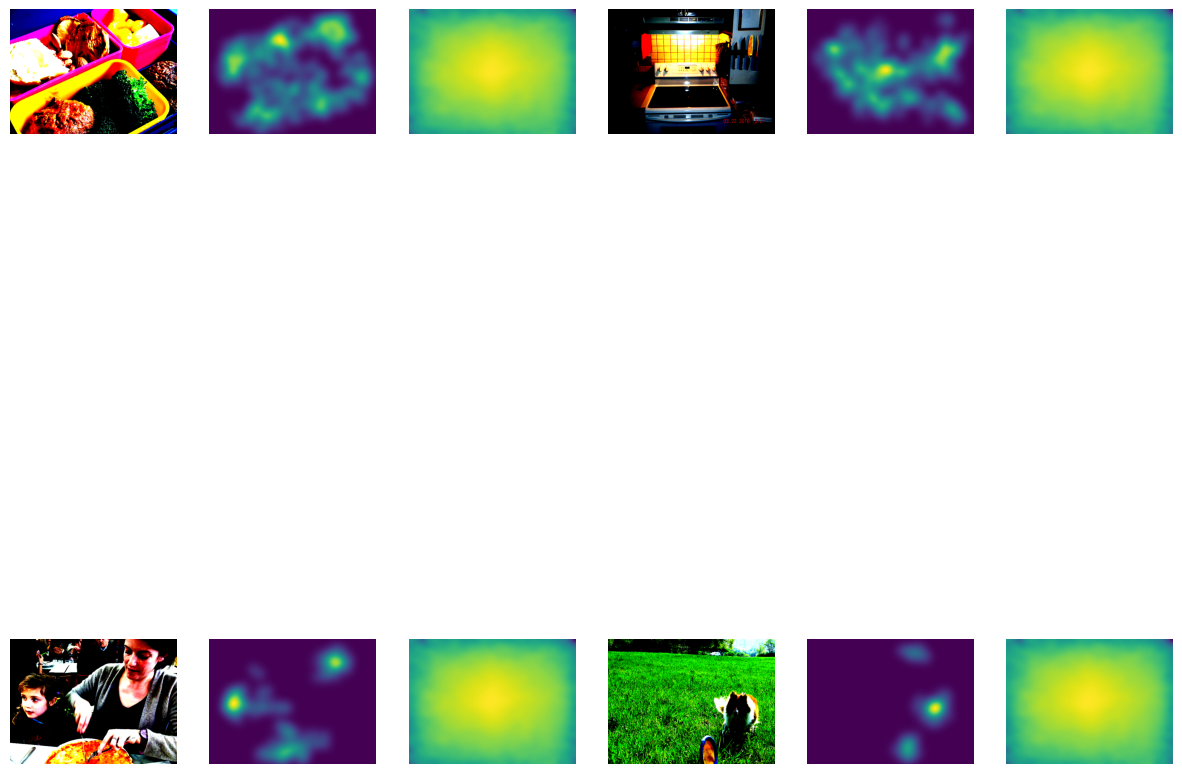

In [13]:
# Display some of the images in the dataset together with their annotations
r, c = [2,6]
fig, ax = plt.subplots(r, c, figsize = (15, 15)) 

k = 0

for data in train_loader:
    x, y, z = data

    # print(x.shape)

    for i in range(r):
        for j in range(0,c,3):
            img = x[k].numpy().transpose(1,2,0)
            ann = y[k].numpy().transpose(1,2,0)
            gauss = z[k].numpy().transpose(1,2,0)
            ax[i, j].imshow(img)
            ax[i, j].axis("off")
            ax[i, j+1].imshow(ann)
            ax[i, j+1].axis("off")
            ax[i, j+2].imshow(gauss)
            ax[i, j+2].axis("off")
            k +=1
    break        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

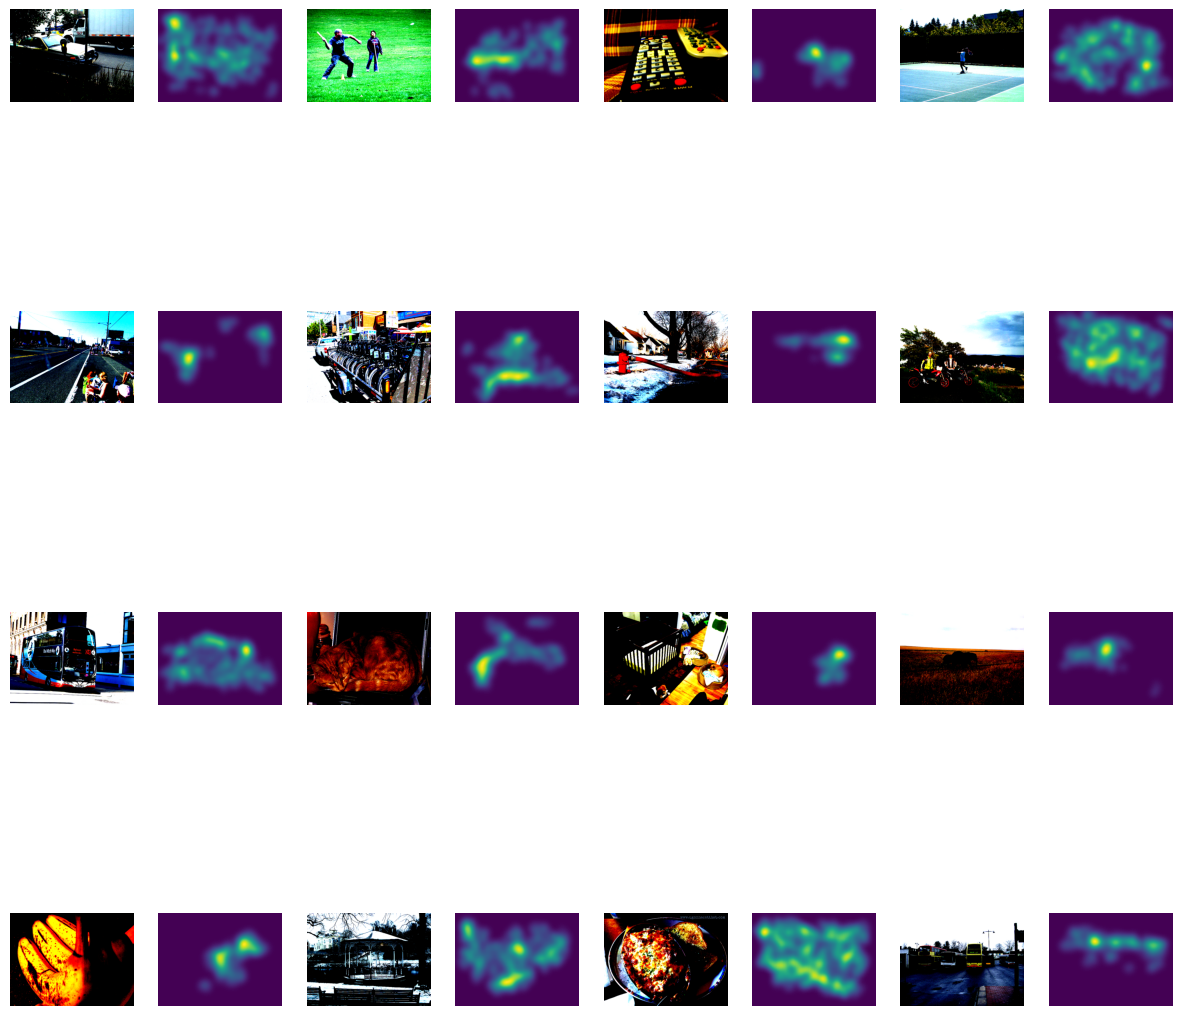

In [14]:
# Display some of the images in the dataset together with their annotations
r, c = [4,8]
fig, ax = plt.subplots(r, c, figsize = (15, 15))

k = 0

for data in valid_loader:
    x, y, z = data

    # print(x.shape)

    for i in range(r):
        for j in range(0,c,2):
            img = x[k].numpy().transpose(1,2,0)
            ann = y[k].numpy().transpose(1,2,0)
            ax[i, j].imshow(img)
            ax[i, j].axis("off")
            ax[i, j+1].imshow(ann)
            ax[i, j+1].axis("off")
            k +=1
    break

### Model train loop

In [15]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self, features, targets):
        super().__init__()
        self.features = features
        self.targets = targets
        #print("Targets are {}".format(targets))
        self.outputs = {}

        for target in targets:
            layer = dict([*self.features.named_modules()])[target]
            layer.register_forward_hook(self.save_outputs_hook(target))

    def save_outputs_hook(self, layer_id: str):
        def fn(_, __, output):
            self.outputs[layer_id] = output.clone()
        return fn

    def forward(self, x):

        self.outputs.clear()
        self.features(x)
        return [self.outputs[target] for target in self.targets]

In [16]:
def upscale(tensor, size):
    tensor_size = torch.tensor(tensor.shape[2:]).type(torch.float32)
    target_size = torch.tensor(size).type(torch.float32)
    factors = torch.ceil(target_size / tensor_size)
    factor = torch.max(factors).type(torch.int64).to(tensor.device)
    assert factor >= 1

    tensor = torch.repeat_interleave(tensor, factor, dim=2)
    tensor = torch.repeat_interleave(tensor, factor, dim=3)

    tensor = tensor[:, :, :size[0], :size[1]]

    return tensor

In [17]:
def gaussian_filter_1d(tensor, dim, sigma, truncate=4, kernel_size=None, padding_mode='replicate', padding_value=0.0):
    sigma = torch.as_tensor(sigma, device=tensor.device, dtype=tensor.dtype)

    if kernel_size is not None:
        kernel_size = torch.as_tensor(kernel_size, device=tensor.device, dtype=torch.int64)
    else:
        kernel_size = torch.as_tensor(2 * torch.ceil(truncate * sigma) + 1, device=tensor.device, dtype=torch.int64)

    kernel_size = kernel_size.detach()

    kernel_size_int = kernel_size.detach().cpu().numpy()

    mean = (torch.as_tensor(kernel_size, dtype=tensor.dtype) - 1) / 2

    grid = torch.arange(kernel_size, device=tensor.device) - mean

    kernel_shape = (1, 1, kernel_size)
    grid = grid.view(kernel_shape)

    grid = grid.detach()

    source_shape = tensor.shape

    tensor = torch.movedim(tensor, dim, len(source_shape)-1)
    dim_last_shape = tensor.shape
    assert tensor.shape[-1] == source_shape[dim]

    # we need reshape instead of view for batches like B x C x H x W
    tensor = tensor.reshape(-1, 1, source_shape[dim])

    padding = (math.ceil((kernel_size_int - 1) / 2), math.ceil((kernel_size_int - 1) / 2))
    tensor_ = F.pad(tensor, padding, padding_mode, padding_value)

    # create gaussian kernel from grid using current sigma
    kernel = torch.exp(-0.5 * (grid / sigma) ** 2)
    kernel = kernel / kernel.sum()

    # convolve input with gaussian kernel
    tensor_ = F.conv1d(tensor_, kernel)
    tensor_ = tensor_.view(dim_last_shape)
    tensor_ = torch.movedim(tensor_, len(source_shape)-1, dim)

    assert tensor_.shape == source_shape

    return tensor_

In [18]:
class GaussianFilterNd(nn.Module):
    """A differentiable gaussian filter"""

    def __init__(self, dims, sigma, truncate=4, kernel_size=None, padding_mode='replicate', padding_value=0.0,
                 trainable=False):
        """Creates a 1d gaussian filter
        Args:
            dims ([int]): the dimensions to which the gaussian filter is applied. Negative values won't work
            sigma (float): standard deviation of the gaussian filter (blur size)
            input_dims (int, optional): number of input dimensions ignoring batch and channel dimension,
                i.e. use input_dims=2 for images (default: 2).
            truncate (float, optional): truncate the filter at this many standard deviations (default: 4.0).
                This has no effect if the `kernel_size` is explicitely set
            kernel_size (int): size of the gaussian kernel convolved with the input
            padding_mode (string, optional): Padding mode implemented by `torch.nn.functional.pad`.
            padding_value (string, optional): Value used for constant padding.
        """
        # IDEA determine input_dims dynamically for every input
        super(GaussianFilterNd, self).__init__()

        self.dims = dims
        self.sigma = nn.Parameter(torch.tensor(sigma, dtype=torch.float32), requires_grad=trainable)  # default: no optimization
        self.truncate = truncate
        self.kernel_size = kernel_size

        # setup padding
        self.padding_mode = padding_mode
        self.padding_value = padding_value

    def forward(self, tensor):
        """Applies the gaussian filter to the given tensor"""
        for dim in self.dims:
            tensor = gaussian_filter_1d(
                tensor,
                dim=dim,
                sigma=self.sigma,
                truncate=self.truncate,
                kernel_size=self.kernel_size,
                padding_mode=self.padding_mode,
                padding_value=self.padding_value,
            )

        return tensor

In [19]:
class Finalizer(nn.Module):
    """Transforms a readout into a gaze prediction
    A readout network returns a single, spatial map of probable gaze locations.
    This module bundles the common processing steps necessary to transform this into
    the predicted gaze distribution:
     - resizing to the stimulus size
     - smoothing of the prediction using a gaussian filter
     - removing of channel and time dimension
     - weighted addition of the center bias
     - normalization
    """

    def __init__(
        self,
        sigma,
        kernel_size=None,
        learn_sigma=False,
        center_bias_weight=1.0,
        learn_center_bias_weight=True,
        saliency_map_factor=4,
    ):
        """Creates a new finalizer
        Args:
            size (tuple): target size for the predictions
            sigma (float): standard deviation of the gaussian kernel used for smoothing
            kernel_size (int, optional): size of the gaussian kernel
            learn_sigma (bool, optional): If True, the standard deviation of the gaussian kernel will
                be learned (default: False)
            center_bias (string or tensor): the center bias
            center_bias_weight (float, optional): initial weight of the center bias
            learn_center_bias_weight (bool, optional): If True, the center bias weight will be
                learned (default: True)
        """
        super(Finalizer, self).__init__()

        self.saliency_map_factor = saliency_map_factor

        self.gauss = GaussianFilterNd([2, 3], sigma, truncate=3, trainable=learn_sigma)
        self.center_bias_weight = nn.Parameter(torch.Tensor([center_bias_weight]), requires_grad=learn_center_bias_weight)

    def forward(self, readout, centerbias):
        """Applies the finalization steps to the given readout"""

        downscaled_centerbias = F.interpolate(
            centerbias.view(centerbias.shape[0], 1, centerbias.shape[1], centerbias.shape[2]),
            scale_factor=1 / self.saliency_map_factor,
            recompute_scale_factor=False,
        )[:, 0, :, :]

        out = F.interpolate(
            readout,
            size=[downscaled_centerbias.shape[1], downscaled_centerbias.shape[2]]
        )

        # apply gaussian filter
        out = self.gauss(out)

        # remove channel dimension
        out = out[:, 0, :, :]

        # add to center bias
        out = out + self.center_bias_weight * downscaled_centerbias

        out = F.interpolate(out[:, np.newaxis, :, :], size=[centerbias.shape[1], centerbias.shape[2]])[:, 0, :, :]

        # normalize
        out = out - out.logsumexp(dim=(1, 2), keepdim=True)

        return out

In [20]:
class LayerNorm(nn.Module):
    r"""Applies Layer Normalization over a mini-batch of inputs as described in
    the paper `Layer Normalization`_ .
    .. math::
        y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
    The mean and standard-deviation are calculated separately over the last
    certain number dimensions which have to be of the shape specified by
    :attr:`normalized_shape`.
    :math:`\gamma` and :math:`\beta` are learnable affine transform parameters of
    :attr:`normalized_shape` if :attr:`elementwise_affine` is ``True``.
    .. note::
        Unlike Batch Normalization and Instance Normalization, which appliesDEEPGAZE
        
        scalar scale and bias for each entire channel/plane with the
        :attr:`affine` option, Layer Normalization applies per-element scale and
        bias with :attr:`elementwise_affine`.
    This layer uses statistics computed from input data in both training and
    evaluation modes.
    Args:
        normalized_shape (int or list or torch.Size): input shape from an expected input
            of size
            .. math::
                [* \times \text{normalized\_shape}[0] \times \text{normalized\_shape}[1]
                    \times \ldots \times \text{normalized\_shape}[-1]]
            If a single integer is used, it is treated as a singleton list, and this module will
            normalize over the last dimension which is expected to be of that specific size.
        eps: a value added to the denominator for numerical stability. Default: 1e-5
        elementwise_affine: a boolean value that when set to ``True``, this module
            has learnable per-element affine parameters initialized to ones (for weights)
            and zeros (for biases). Default: ``True``.
    Shape:
        - Input: :math:`(N, *)`
        - Output: :math:`(N, *)` (same shape as input)
    Examples::
        >>> input = torch.randn(20, 5, 10, 10)
        >>> # With Learnable Parameters
        >>> m = nn.LayerNorm(input.size()[1:])
        >>> # Without Learnable Parameters
        >>> m = nn.LayerNorm(input.size()[1:], elementwise_affine=False)
        >>> # Normalize over last two dimensions
        >>> m = nn.LayerNorm([10, 10])
        >>> # Normalize over last dimension of size 10
        >>> m = nn.LayerNorm(10)
        >>> # Activating the module
        >>> output = m(input)
    .. _`Layer Normalization`: https://arxiv.org/abs/1607.06450
    """
    __constants__ = ['features', 'weight', 'bias', 'eps', 'center', 'scale']

    def __init__(self, features, eps=1e-12, center=True, scale=True):
        super(LayerNorm, self).__init__()
        self.features = features
        self.eps = eps
        self.center = center
        self.scale = scale

        if self.scale:
            self.weight = nn.Parameter(torch.Tensor(self.features))
        else:
            self.register_parameter('weight', None)

        if self.center:
            self.bias = nn.Parameter(torch.Tensor(self.features))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        if self.scale:
            nn.init.ones_(self.weight)

        if self.center:
            nn.init.zeros_(self.bias)

    def adjust_parameter(self, tensor, parameter):
        return torch.repeat_interleave(
            torch.repeat_interleave(
                parameter.view(-1, 1, 1),
                repeats=tensor.shape[2],
                dim=1),
            repeats=tensor.shape[3],
            dim=2
        )

    def forward(self, input):
        normalized_shape = (self.features, input.shape[2], input.shape[3])
        weight = self.adjust_parameter(input, self.weight)
        bias = self.adjust_parameter(input, self.bias)
        return F.layer_norm(
            input, normalized_shape, weight, bias, self.eps)

    def extra_repr(self):
        return '{features}, eps={eps}, ' \
            'center={center}, scale={scale}'.format(**self.__dict__)

In [21]:
class Bias(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.bias = nn.Parameter(torch.zeros(channels))

    def forward(self, tensor):
        return tensor + self.bias[np.newaxis, :, np.newaxis, np.newaxis]

    def extra_repr(self):
        return f'channels={self.channels}'

In [22]:
class DeepGazeII(torch.nn.Module):
    def __init__(self, features, readout_network, downsample=2, readout_factor=16, saliency_map_factor=2, initial_sigma=8.0):
        super().__init__()

        self.readout_factor = readout_factor
        self.saliency_map_factor = saliency_map_factor

        self.features = features

        for param in self.features.parameters():
            param.requires_grad = False
        self.features.eval()

        self.readout_network = readout_network
        self.finalizer = Finalizer(
            sigma=initial_sigma,
            learn_sigma=True,
            saliency_map_factor=self.saliency_map_factor,
        )
        self.downsample = downsample

    def forward(self, x, centerbias):
        orig_shape = x.shape
        x = F.interpolate(
            x,
            scale_factor=1 / self.downsample,
            recompute_scale_factor=False,
        )
        x = self.features(x)

        readout_shape = [math.ceil(orig_shape[2] / self.downsample / self.readout_factor), math.ceil(orig_shape[3] / self.downsample / self.readout_factor)]
        x = [F.interpolate(item, readout_shape) for item in x]

        x = torch.cat(x, dim=1)
        x = self.readout_network(x)
        x = self.finalizer(x, centerbias)

        return x

    def train(self, mode=True):
        self.features.eval()
        self.readout_network.train(mode=mode)
        self.finalizer.train(mode=mode)

In [23]:
readout_network = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(512, 1, (1, 1), bias=False)),
        ]))

In [24]:
class Normalizer(nn.Module):
    def __init__(self):
        super(Normalizer, self).__init__()
        mean = np.array([0.485, 0.456, 0.406])
        mean = mean[:, np.newaxis, np.newaxis]

        std = np.array([0.229, 0.224, 0.225])
        std = std[:, np.newaxis, np.newaxis]

        # don't persist to keep old checkpoints working
        self.register_buffer('mean', torch.tensor(mean), persistent=False)
        self.register_buffer('std', torch.tensor(std), persistent=False)


    def forward(self, tensor):
        tensor = tensor / 255.0

        tensor -= self.mean
        tensor /= self.std

        return tensor

In [25]:
class RGBResNet34(nn.Sequential):
    def __init__(self):
        super(RGBResNet34, self).__init__()
        self.resnet = torchvision.models.resnet34(pretrained=True)
        self.normalizer = Normalizer()
        super(RGBResNet34, self).__init__(self.normalizer, self.resnet)


class RGBResNet50(nn.Sequential):
    def __init__(self):
        super(RGBResNet50, self).__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        self.normalizer = Normalizer()
        super(RGBResNet50, self).__init__(self.normalizer, self.resnet)


class RGBResNet50_alt(nn.Sequential):
    def __init__(self):
        super(RGBResNet50, self).__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        self.normalizer = Normalizer()
        state_dict = torch.load("Resnet-AlternativePreTrain.pth")
        model.load_state_dict(state_dict)
        super(RGBResNet50, self).__init__(self.normalizer, self.resnet)



class RGBResNet101(nn.Sequential):
    def __init__(self):
        super(RGBResNet101, self).__init__()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        self.normalizer = Normalizer()
        super(RGBResNet101, self).__init__(self.normalizer, self.resnet)

In [53]:
# Download a pretarined model. This can be changed to any other version of resnet
resnet_model101 = RGBResNet50()

/home/ubuntu/anaconda3/envs/idl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/idl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:00<00:00, 305MB/s]


In [54]:
def build_saliency_network(input_channels):
    return nn.Sequential(OrderedDict([
        ('layernorm0', LayerNorm(input_channels)),
        ('conv0', nn.Conv2d(input_channels, 8, (1, 1), bias=False)),
        ('bias0', nn.Bias(8)),
        ('softplus0', nn.Softplus()),

        ('layernorm1', LayerNorm(8)),
        ('conv1', nn.Conv2d(8, 16, (1, 1), bias=False)),
        ('bias1', nn.Bias(16)),
        ('softplus1', nn.Softplus()),

        ('layernorm2', LayerNorm(16)),
        ('conv2', nn.Conv2d(16, 1, (1, 1), bias=False)),
        ('bias2', nn.Bias(1)),
        ('softplus2', nn.Softplus()),
    ]))

In [55]:
# Readout network, we can add more layers to the readout network
# However the first input of the read out network depends on the feature you extracted
# For instance, ['1.layer4.2.bn3'] had a layer size of 2048, that's why the input to the conv2d is 2048
# resnet101_read_out = nn.Sequential(OrderedDict([
#             ('conv0', nn.Conv2d(2048, 1, (1, 1), bias=False)),
#             ('norm0', LayerNorm())
#         ]))

read101_readout = nn.Sequential(OrderedDict([
    ('layernorm0', LayerNorm(2048)),
    ('conv0', nn.Conv2d(2048, 8, (1, 1), bias=False)),
    ('bias0', Bias(8)),
    ('softplus0', nn.Softplus()),

    ('layernorm1', LayerNorm(8)),
    ('conv1', nn.Conv2d(8, 16, (1, 1), bias=False)),
    ('bias1', Bias(16)),
    ('softplus1', nn.Softplus()),

    ('layernorm2', LayerNorm(16)),
    ('conv2', nn.Conv2d(16, 1, (1, 1), bias=False)),
    ('bias2', Bias(1)),
    ('softplus2', nn.Softplus()),
]))

In [56]:
# Extract the layers in the model and display them
layers = dict([*RGBResNet101().named_modules()])
layers.keys()

/home/ubuntu/anaconda3/envs/idl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dict_keys(['', '0', '1', '1.conv1', '1.bn1', '1.relu', '1.maxpool', '1.layer1', '1.layer1.0', '1.layer1.0.conv1', '1.layer1.0.bn1', '1.layer1.0.conv2', '1.layer1.0.bn2', '1.layer1.0.conv3', '1.layer1.0.bn3', '1.layer1.0.relu', '1.layer1.0.downsample', '1.layer1.0.downsample.0', '1.layer1.0.downsample.1', '1.layer1.1', '1.layer1.1.conv1', '1.layer1.1.bn1', '1.layer1.1.conv2', '1.layer1.1.bn2', '1.layer1.1.conv3', '1.layer1.1.bn3', '1.layer1.1.relu', '1.layer1.2', '1.layer1.2.conv1', '1.layer1.2.bn1', '1.layer1.2.conv2', '1.layer1.2.bn2', '1.layer1.2.conv3', '1.layer1.2.bn3', '1.layer1.2.relu', '1.layer2', '1.layer2.0', '1.layer2.0.conv1', '1.layer2.0.bn1', '1.layer2.0.conv2', '1.layer2.0.bn2', '1.layer2.0.conv3', '1.layer2.0.bn3', '1.layer2.0.relu', '1.layer2.0.downsample', '1.layer2.0.downsample.0', '1.layer2.0.downsample.1', '1.layer2.1', '1.layer2.1.conv1', '1.layer2.1.bn1', '1.layer2.1.conv2', '1.layer2.1.bn2', '1.layer2.1.conv3', '1.layer2.1.bn3', '1.layer2.1.relu', '1.layer2.2', '

In [57]:
# Extract features from a particular layer in the model
resnet101_model_feature = FeatureExtractor(RGBResNet101(), ['1.layer4.2.bn3'])

In [58]:
# Create the deepgazeII model by passing the featues and the readout network
deepgaze_res101 = DeepGazeII(resnet101_model_feature, read101_readout) #resnet101_read_out

In [59]:
# Transfer the model to the GPU
deepgaze_res101.to(DEVICE)

DeepGazeII(
  (features): FeatureExtractor(
    (features): RGBResNet101(
      (0): Normalizer()
      (1): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-0

In [60]:
def _general_auc(positives, negatives):
    if len(positives) == 1:
        return auc_for_one_positive(positives[0], negatives)
    else:
        return general_roc(positives, negatives)[0]

In [61]:
def log_likelihood(log_density, fixation_mask, weights=None):
    if weights is None:
       weights = torch.ones(log_density.shape[0])

    weights = len(weights) * weights.view(-1, 1, 1) / weights.sum()

    if isinstance(fixation_mask, torch.sparse.IntTensor):
        dense_mask = fixation_mask.to_dense()
    else:
        dense_mask = fixation_mask
    fixation_count = dense_mask.sum(dim=(-1, -2), keepdim=True)
    # print(log_density.shape)
    # print(dense_mask.shape)
    ll = torch.mean(
        weights * torch.sum(log_density * dense_mask, dim=(-1, -2), keepdim=True) / fixation_count
    )
    return (ll + np.log(log_density.shape[-1] * log_density.shape[-2])) / np.log(2)

In [62]:
def nss(log_density, fixation_mask, weights=None):
    weights = len(weights) * weights.view(-1, 1, 1) / weights.sum()
    if isinstance(fixation_mask, torch.sparse.IntTensor):
        dense_mask = fixation_mask.to_dense()
    else:
        dense_mask = fixation_mask

    fixation_count = dense_mask.sum(dim=(-1, -2), keepdim=True)

    density = torch.exp(log_density)
    mean, std = torch.std_mean(density, dim=(-1, -2), keepdim=True)
    saliency_map = (density - mean) / std

    nss = torch.mean(
        weights * torch.sum(saliency_map * dense_mask, dim=(-1, -2), keepdim=True) / fixation_count
    )
    return nss

In [63]:
def auc(log_density, fixation_mask, weights=None):
    weights = len(weights) * weights / weights.sum()

    # TODO: This doesn't account for multiple fixations in the same location!
    def image_auc(log_density, fixation_mask):
        if isinstance(fixation_mask, torch.sparse.IntTensor):
            dense_mask = fixation_mask.to_dense()
        else:
            dense_mask = fixation_mask

        positives = torch.masked_select(log_density, dense_mask.type(torch.bool)).detach().cpu().numpy().astype(np.float64)
        negatives = log_density.flatten().detach().cpu().numpy().astype(np.float64)

        auc = _general_auc(positives, negatives)

        return torch.tensor(auc)

    return torch.mean(weights.cpu() * torch.tensor([
        image_auc(log_density[i], fixation_mask[i]) for i in range(log_density.shape[0])
    ]))

In [64]:
optimizer = torch.optim.AdamW(deepgaze_res101.parameters(), lr = config['lr'])

In [38]:
def train_epoch(model, dataset, optimizer, device):
    model.train()
    losses = []
    batch_weights = []
    pbar = tqdm(dataset)
    for batch in pbar:
        optimizer.zero_grad()
        x, y, z = batch
        image = x.to(device)
        fixation = y.to(device)
        gauss = z.mean(dim=0).to(device)
        weights = torch.ones(x.shape[0]).to(device)
        
        log_density = model(image, gauss)
        # print("Train loop",log_density.shape)

        loss = -log_likelihood(log_density, fixation, weights=weights)
        losses.append(loss.detach().cpu().numpy())

        batch_weights.append(weights.detach().cpu().numpy().sum())

        pbar.set_description('Train Loss: {:.05f}'.format(np.average(losses, weights=batch_weights)))

        loss.backward()

        optimizer.step()

    return np.average(losses, weights=batch_weights)

In [39]:
def eval_epoch(model, dataset, device, metrics= None):
    model.eval()
    if metrics is None:
        metrics = ['LL', 'NSS', 'AUC'] # 'IG',

    metric_scores = {}
    metric_functions = {
    'LL': log_likelihood,
    'NSS': nss,
    'AUC': auc,
    }
    batch_weights = []

    with torch.no_grad():
        pbar = tqdm(dataset)
        for batch in pbar:
            optimizer.zero_grad()
            x, y, z = batch
            image = x.to(device)
            fixation = y.to(device)
            centerbias = z.mean(dim=0).to(device)
            weights = torch.ones(x.shape[0]).to(device)
            
            log_density = model(image, centerbias)

            for metric_name, metric_fn in metric_functions.items():
                if metric_name not in metrics:
                    continue
                metric_scores.setdefault(metric_name, []).append(metric_fn(log_density, fixation, weights=weights).detach().cpu().numpy())
            batch_weights.append(weights.detach().cpu().numpy().sum())

            for display_metric in ['LL', 'NSS', 'AUC']:
                if display_metric in metrics:
                    pbar.set_description('Val Loss: {} {:.05f}'.format(display_metric, np.average(metric_scores[display_metric], weights=batch_weights)))
                    break

    data = {metric_name: np.average(scores, weights=batch_weights) for metric_name, scores in metric_scores.items()}

    return data


In [65]:
wandb.login(key="89dab584862022063dce5dc19636c38ad5e690ad") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


True

In [70]:
# Create your wandb run
run = wandb.init(
    name = "deepgazeIIE-resnet50-checkpoints", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "saliency-prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

In [71]:
""" Training the model """
best_met = 0
# scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-7)

for epoch in range(config['epochs']):
    
    curr_lr = float(optimizer.param_groups[0]['lr'])

    print(f"Epoch: {epoch + 1}/{config['epochs']} Lr: {curr_lr}")

    train_loss = train_epoch(deepgaze_res101, train_loader, optimizer, DEVICE)
  
    # Validating after every 5 epochs 
    if epoch != 0 and epoch % 5 == 0:
        val = eval_epoch(deepgaze_res101, valid_loader, DEVICE)

    if epoch == 0:
      val = eval_epoch(deepgaze_res101, valid_loader, DEVICE)  
      best_loss = val['NSS']

    wandb.log({"train_loss":train_loss, 'validation': val, "learning_Rate": curr_lr})
    
    #If you are using a scheduler in your train function within your iteration loop, you may want to log
    #your learning rate differently 

    #Save model in drive location if val_acc is better than best recorded val_acc
    if val['NSS'] >= best_met:
      print("Saving model")
      torch.save({'model_state_dict':deepgaze_res101.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  #'scheduler_state_dict':scheduler.state_dict(),
                  'val': val, 
                  'epoch': epoch}, './checkpoint.pth')
      best_loss = val['NSS']
      wandb.save('checkpoint.pth')
      
run.finish()

Epoch: 1/30 Lr: 0.0001


Val Loss: LL 0.67785: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [06:16<00:00,  4.77s/it]


Saving model
Epoch: 2/30 Lr: 0.0001


Train Loss: -0.66299: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:14<00:00,  1.17it/s]


Saving model
Epoch: 3/30 Lr: 0.0001


Train Loss: -0.66312: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:15<00:00,  1.16it/s]


Saving model
Epoch: 4/30 Lr: 0.0001


Train Loss: -0.66325: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:16<00:00,  1.15it/s]


Saving model
Epoch: 5/30 Lr: 0.0001


Train Loss: -0.66336: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:14<00:00,  1.17it/s]


Saving model
Epoch: 6/30 Lr: 0.0001


Val Loss: LL 0.67832: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [06:16<00:00,  4.76s/it]


Saving model
Epoch: 7/30 Lr: 0.0001


Train Loss: -0.66358: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:14<00:00,  1.17it/s]


Saving model
Epoch: 8/30 Lr: 0.0001


Train Loss: -0.66369: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:15<00:00,  1.16it/s]


Saving model
Epoch: 9/30 Lr: 0.0001


Train Loss: -0.66379: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:16<00:00,  1.15it/s]


Saving model
Epoch: 10/30 Lr: 0.0001


Train Loss: -0.66406: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:13<00:00,  1.17it/s]


Saving model
Epoch: 13/30 Lr: 0.0001


Train Loss: -0.66415: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:15<00:00,  1.16it/s]


Saving model
Epoch: 14/30 Lr: 0.0001


Train Loss: -0.66423: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:13<00:00,  1.18it/s]


Saving model
Epoch: 15/30 Lr: 0.0001


Train Loss: -0.66431: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:13<00:00,  1.17it/s]


Saving model
Epoch: 16/30 Lr: 0.0001


Val Loss: LL 0.67904: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [06:15<00:00,  4.76s/it]


Saving model
Epoch: 17/30 Lr: 0.0001


Train Loss: -0.66446: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:14<00:00,  1.17it/s]


Saving model
Epoch: 18/30 Lr: 0.0001


Train Loss: -0.66453: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:13<00:00,  1.17it/s]


Saving model
Epoch: 19/30 Lr: 0.0001


Train Loss: -0.66460: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:14<00:00,  1.16it/s]


Saving model
Epoch: 20/30 Lr: 0.0001


Train Loss: -0.66467: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:16<00:00,  1.15it/s]


Saving model
Epoch: 21/30 Lr: 0.0001


Val Loss: LL 0.67932: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [06:15<00:00,  4.76s/it]


Saving model
Epoch: 22/30 Lr: 0.0001


Train Loss: -0.66479: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:13<00:00,  1.18it/s]


Saving model
Epoch: 23/30 Lr: 0.0001


Train Loss: -0.66485: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:13<00:00,  1.18it/s]


Saving model
Epoch: 24/30 Lr: 0.0001


Train Loss: -0.66490: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:14<00:00,  1.17it/s]


Saving model
Epoch: 25/30 Lr: 0.0001


Train Loss: -0.66496: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:16<00:00,  1.15it/s]


Saving model
Epoch: 26/30 Lr: 0.0001


Val Loss: LL 0.67954: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [06:15<00:00,  4.76s/it]


Saving model
Epoch: 27/30 Lr: 0.0001


Train Loss: -0.66505: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:14<00:00,  1.17it/s]


Saving model
Epoch: 28/30 Lr: 0.0001


Train Loss: -0.66510: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:15<00:00,  1.16it/s]


Saving model
Epoch: 29/30 Lr: 0.0001


Train Loss: -0.66514: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:15<00:00,  1.16it/s]


Saving model
Epoch: 30/30 Lr: 0.0001


Train Loss: -0.66518: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:13<00:00,  1.18it/s]


Saving model


learning_Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
learning_Rate,0.0001
train_loss,-0.66518


In [68]:
# Loading checkpoints 

from torch.nn import DataParallel

path = "checkpoint.pth"

checkpoint = torch.load(path)
deepgaze_res101.load_state_dict(checkpoint['model_state_dict'])

deepgaze_res101 = DataParallel(deepgaze_res101)